In [32]:
#Import packages
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
from matplotlib.patheffects import Stroke, Normal, withStroke

#Read csv file
df = pd.read_csv('Footballdata/RM/RM.csv', encoding='latin-1')

#Take shots data only
df = df[df['type/displayName'].isin(['Goal', 'SavedShot'])].copy()

#obtain relevant values
df = df[['playername','type/displayName','goalMouthY','goalMouthZ']]

#rename it to x and y
df.rename(columns = {'goalMouthY':'x', 'goalMouthZ':'y'}, inplace = True)

#Goal x coordinate (45,55), Goal y coordinate (0,36.1)
df = df[(df['x'].between(45,55)) & (df['y'].between(0,36.1))]

df['x'] = df['x']-100
df['x'] = df['x'].abs()

#df['x'] = (df['x']/55)*25

#The size of the goal
width = 25
height = 10

#5 x 2 grid
increment_x = int(width / 5)
increment_y = int(height / 2)

#scale value based on the shot locations of the scatter plots
#NewValue = (((OldValue - OldMin) * (NewMax - NewMin)) / (OldMax - OldMin)) + NewMin
df['x'] = (((df['x'] - 45.5) * (24.25 - 0.25)) / (54.5 - 45.5)) + 0.25
df['y'] = (((df['y'] - 0) * (10 - 0)) / (36 - 0)) + 0


# Assign intervals with binning
bins_x = range(0, width + 1, increment_x)
bins_y = range(0, height + 1, increment_y)

#Using cut function to assign bin values
df['bins_x'] = pd.cut(df['x'], bins_x)
df['bins_y'] = pd.cut(df['y'], bins_y)

#Shot Counter
df['shot_aux'] = 1

#df

In [33]:
#Group in a different dataframe
df1 = df[['playername','bins_x','bins_y','shot_aux','x','y']].groupby(['bins_x','bins_y','playername'])['shot_aux'].sum().reset_index()

#Count all shots
total_shots = df.groupby(['playername'])['shot_aux'].sum().reset_index()
total_shots.columns = ['playername','total']

#Merge it back & calculate the percentage
df1 = pd.merge(df1,total_shots, how = 'left', on = 'playername')
df1['shot_pct'] = df1['shot_aux']/df1['total']
#df1

In [29]:
import ipywidgets as widgets

options = df["playername"].unique()
options = options.tolist()

options = [x for x in options if str(x) != 'nan']
playerlist = widgets.Combobox(
    placeholder='Enter a name',
    options=options,
    description='Player:',
    ensure_option=True,
    disabled=False
)
playerlist

Combobox(value='', description='Player:', ensure_option=True, options=('381713', '74603', '33404', '13812', 'K…

In [34]:
pd.set_option('mode.chained_assignment', None)

#Assign player
player = playerlist.value

#player='Erling Haaland'
#Filter for player
df1 = df1.loc[(df1['playername'] == player)]

#replace NaN values with 0
df1.shot_pct.fillna(0.0, inplace=True)

#Obtain the shot percentages as a list, so that it can be printed on the graph
data = df1['shot_pct'].to_list()

#Filter for player goal, to obtain shot locations
goaldf = df.loc[((df['playername'] == player) & (df['type/displayName'] == 'Goal'))]

shotdf = df.loc[((df['playername'] == player) & (df['type/displayName'] == 'SavedShot'))]

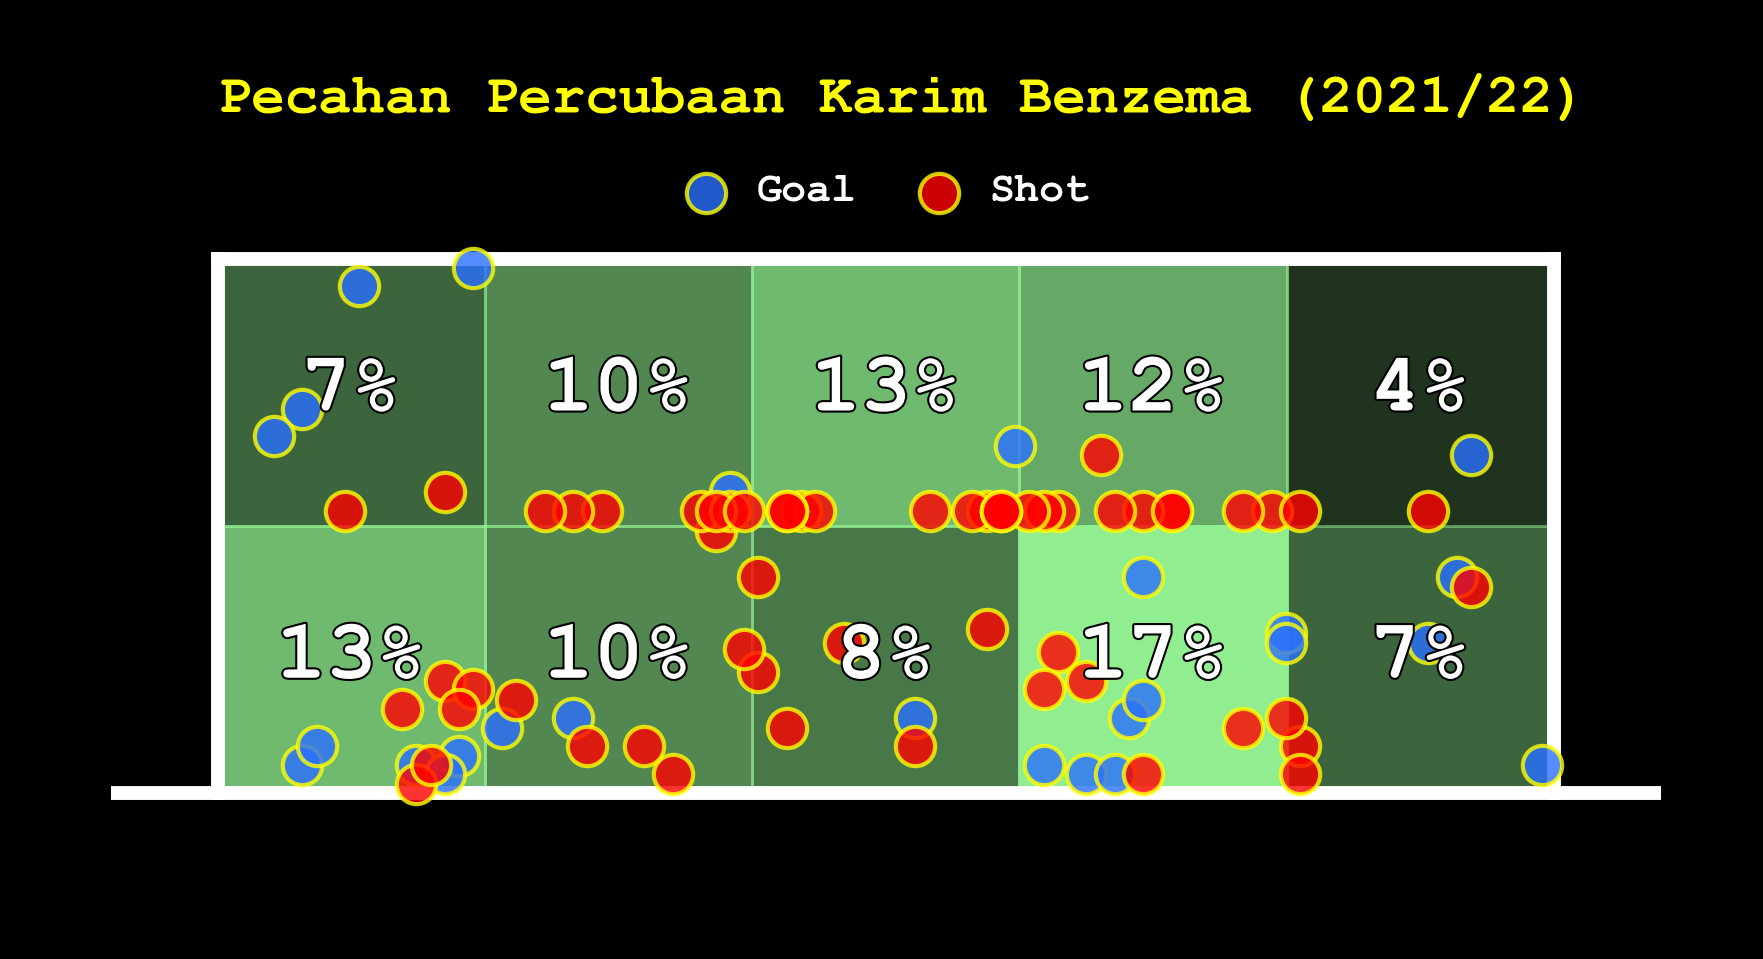

In [49]:
fig, ax = plt.subplots(figsize = (10,6), dpi = 200, facecolor = 'black')
ax.axis('equal')

# -- The size of the goal
width = 25
height = 10

# -- The left & right post
ax.plot([0,0],[0,height], color = 'w', lw = 5)
ax.plot([width,width],[0,height], color = 'w', lw = 5)

# -- The top post
ax.plot([0,width],[height,height], color = 'w', lw = 5)

max_data = max(data)
scaled_data = [x/max_data for x in data]

#plot the goals
plt.scatter(goaldf.x, goaldf.y, marker='o', s=200, c='#2a70ff', linewidth = 1.5, 
            edgecolor='yellow', zorder=4, alpha = 0.8, label='Goal')

#plot the shots
plt.scatter(shotdf.x, shotdf.y, marker='o', s=200, c='red', linewidth = 1.5, 
            edgecolor='yellow', zorder=4, alpha = 0.8, label='Shot')

# -- 5 x 2 grid
increment_x = int(width / 5)
increment_y = int(height / 2)

i = 0 
x = 0
while x < width:
  for y in range(0, height, increment_y):
    rect = patches.Rectangle(
            (x, y),  # bottom left starting position (x,y)
            increment_x,  # width
            increment_y,  # height
            ec='lightgreen',
            fc='lightgreen',
            alpha = scaled_data[i], # <---- the transparency
            zorder=-1
          )
    
    ax.add_patch(rect)
    
    # -- Anotate the counter (i) and choose color depending on value
    if scaled_data[i] < .5:
        color_text = 'black'
        fore_color ='w'
    else:
        color_text = 'w'
        fore_color = 'black'

    # -- Anotate the counter (i)
    label_ = ax.text(
              x = x + increment_x/2, y = y + increment_y/2,
              s = f'{data[i]:.0%}', # <----- the data label
              color = 'white',
              fontsize = 30,
              zorder = 5,
              fontfamily = 'Courier New',
              fontweight = 'bold',
              va = 'center',
              ha = 'center'
            )
    
        # Set path effects to ensure readability
    label_.set_path_effects([Stroke(linewidth=1.5, foreground='black'), Normal()])

    i += 1

  # -- Once we've placed the top & bottom rectangles we move right.
  x = x + increment_x
    
# -- Add the player's name
player_ = ax.text(
          x = 0, y = height + 3,
          s = "Pecahan Percubaan " + player + " (2021/22)",
          color = 'yellow',
          va = 'center',
          ha = 'left',
          fontfamily = 'Courier New',
          fontweight = 'bold',
          fontsize = 20
        )

# -- Set axes limits and remove ticks
ax.set_xlim(-2,width + 2)
ax.set_ylim(0,height + 2)
ax.set_axis_off()

# -- Draw the lower border
ax.plot([-2,width + 2],[0,0], color = 'w', marker = 'None', lw = 5, zorder = 3)

# setup the legend
legend = ax.legend(loc='center left', bbox_to_anchor=(0.35, 0.81),facecolor='#000000', edgecolor='None',
                   labelspacing=10, ncol=2)

for text in legend.get_texts():
    text.set_fontsize(15)
    text.set_fontfamily("Courier New")
    text.set_fontweight("bold")
    text.set_color('white')

# -- Spacing
ax.text(27, -2.5, 'space', va='center', ha='left', fontsize=10, color='black',
        fontweight = "bold",fontfamily = "Courier New")

ax.text(-3.7, -2.5, 'space', va='center', ha='left', fontsize=10, color='black',
        fontweight = "bold",fontfamily = "Courier New")

plt.show()